# CC3045 — Laboratorio 8: Pronóstico de Demanda con LSTM/GRU/Conv1D

- Diego Valenzuela: 22309
- Gerson Ramierez: 22281

In [1]:
import sys, platform, os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Python:", sys.version)
print("OS:", platform.platform())
print("TensorFlow:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


2025-10-03 12:46:30.042983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-03 12:46:30.081094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-03 12:46:30.092341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-03 12:46:30.122586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 12:46:31.700427: W tensorflow/compiler/tf2

Python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
OS: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35
TensorFlow: 2.17.0
Num GPUs Available: 1


I0000 00:00:1759517193.518446    8544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759517193.649252    8544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759517193.649400    8544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# CC3045 — Laboratorio 8: Pronóstico de demanda con LSTM
**Dataset**: Store Item Demand Forecasting (Kaggle)  
**Objetivo**: Predecir 3 meses de ventas (multi-step) para 50 ítems en 10 tiendas.  
**Entorno**: WSL + TensorFlow GPU.

**Checklist del laboratorio**  
1) Limpieza/transformación.  
2) División temporal: train, validación y test (los últimos 3 meses son test).  
3) Ventaneo (windowing) y generación de secuencias.  
4) Modelo (LSTM) + early stopping.  
5) Métricas (MAE, MSE, RMSE) en test.  
6) Forecast 3 meses + visualizaciones.  



### 1. Imports, semillas y paths

In [2]:
import os, sys, warnings, random, math, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = "data"
TRAIN_FP = os.path.join(DATA_DIR, "train.csv")
TEST_FP  = os.path.join(DATA_DIR, "test.csv")
SUB_FP   = os.path.join(DATA_DIR, "sample_submission.csv")

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
for p in [TRAIN_FP, TEST_FP, SUB_FP]:
    assert os.path.exists(p), f"Falta archivo: {p}"


2025-10-03 12:52:24.586048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-03 12:52:24.774680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-03 12:52:24.829658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-03 12:52:25.224252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 12:52:27.792321: W tensorflow/compiler/tf2

Python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
TensorFlow: 2.17.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1759517551.452493    8655 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759517551.947261    8655 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759517551.947400    8655 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### 2. Cargar y explorar

In [3]:
df = pd.read_csv(TRAIN_FP, parse_dates=["date"])
df = df.sort_values(["store","item","date"]).reset_index(drop=True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
# Chequeos básicos
assert set(["date","store","item","sales"]).issubset(df.columns)
print("Nulos por columna:\n", df.isna().sum())
print("Rango de fechas:", df["date"].min(), "→", df["date"].max())
print("Series:", df[["store","item"]].drop_duplicates().shape[0])


Nulos por columna:
 date     0
store    0
item     0
sales    0
dtype: int64
Rango de fechas: 2013-01-01 00:00:00 → 2017-12-31 00:00:00
Series: 500


### 3. Limpieza mínima y transformación

In [5]:
# Coerción y saneo mínimo
df["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df = df.dropna(subset=["sales"])
df["sales"] = df["sales"].astype(np.float32**División temporal (train/val/test)**  
La consigna exige que el **test sean los 3 meses más recientes**. Se separa por fecha (time-based split). :contentReference[oaicite:9]{index=9}



**División temporal (train/val/test)**  
La consigna exige que el **test sean los 3 meses más recientes**. Se separa por fecha (time-based split).

### 4. Split por tiempo (últimos 90 días = test)

In [6]:
# Últimos 90 días como test
PRED_STEPS = 90  # 3 meses aprox
max_date = df["date"].max()
test_start = max_date - pd.Timedelta(days=PRED_STEPS-1)

df_trainval = df[df["date"] < test_start].copy()
df_test     = df[df["date"] >= test_start].copy()

# Deja ~1 mes (30 días) para validación justo antes de test
VAL_DAYS = 30
val_start = test_start - pd.Timedelta(days=VAL_DAYS)

df_train = df_trainval[df_trainval["date"] < val_start].copy()
df_val   = df_trainval[df_trainval["date"] >= val_start].copy()

print(df_train["date"].min(), df_train["date"].max(), "-> TRAIN")
print(df_val["date"].min(),   df_val["date"].max(),   "-> VAL")
print(df_test["date"].min(),  df_test["date"].max(),  "-> TEST (90 días)")


2013-01-01 00:00:00 2017-09-02 00:00:00 -> TRAIN
2017-09-03 00:00:00 2017-10-02 00:00:00 -> VAL
2017-10-03 00:00:00 2017-12-31 00:00:00 -> TEST (90 días)


**Estrategia de modelado**  
Haremos un **modelo univariado por serie** (sales solamente), pero entrenado **de forma global** concatenando ventanas de todas las series (store-item). La red **LSTM** recibirá una ventana de longitud `WINDOW` y predecirá **los próximos 90 pasos (multi-step)** como vector. Esto satisface el requerimiento de “pronóstico de 3 meses”.


### 5. Escalado por serie (solo usando train)

In [13]:
# Escalado z-score PER SERIE usando solo TRAIN para evitar fugas de info
from collections import defaultdict

stats = {}  # (mu, sigma) por (store,item)

def fit_stats(df_):
    g = df_.groupby(["store","item"])["sales"]
    mu = g.transform("mean")
    sd = g.transform("std").replace(0, 1.0)  # evitar división por 0
    return mu, sd

# calculamos por serie con TRAIN
for (s,i), g in df_train.groupby(["store","item"]):
    mu = g["sales"].mean()
    sd = g["sales"].std()
    if sd == 0 or np.isnan(sd): sd = 1.0
    stats[(s,i)] = (float(mu), float(sd))

def standardize(df_):
    df_ = df_.copy()
    mus = []; sds = []
    for idx, row in df_[["store","item"]].iterrows():
        mu, sd = stats.get((row["store"], row["item"]), (0.0, 1.0))
        mus.append(mu); sds.append(sd)
    df_["mu"] = mus; df_["sd"] = sds
    df_["y"] = (df_["sales"] - df_["mu"]) / df_["sd"]
    return df_

df_train_s = standardize(df_train)
df_val_s   = standardize(df_val)
df_test_s  = standardize(df_test)


### 6. Windowing (generación de secuencias)

In [14]:
WINDOW = 60     # pasos de historia
HORIZON = PRED_STEPS  # 90

def make_windows_for_series(y, window, horizon):
    Xs, Ys = [], []
    for t in range(len(y) - window - horizon + 1):
        Xs.append(y[t:t+window])
        Ys.append(y[t+window:t+window+horizon])
    if not Xs:
        return np.empty((0, window), dtype=np.float32), np.empty((0, horizon), dtype=np.float32)
    return np.stack(Xs).astype(np.float32), np.stack(Ys).astype(np.float32)

def build_dataset(df_s, window=WINDOW, horizon=HORIZON):
    X_list, Y_list = [], []
    for (s,i), g in df_s.groupby(["store","item"]):
        y = g.sort_values("date")["y"].values
        X, Y = make_windows_for_series(y, window, horizon)
        if len(X):
            X_list.append(X); Y_list.append(Y)
    if not X_list:
        return np.empty((0, window), np.float32), np.empty((0, horizon), np.float32)
    X = np.concatenate(X_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)
    return X, Y

X_train, y_train = build_dataset(df_train_s)
X_val,   y_val   = build_dataset(df_val_s)

X_train.shape, y_train.shape, X_val.shape, y_val.shape


((778500, 60), (778500, 90), (0, 60), (0, 90))

In [15]:
X_train = X_train[..., None]
X_val   = X_val[..., None]

X_train.shape, X_val.shape

((778500, 60, 1), (0, 60, 1))

### 7. Modelo LSTM + early stopping

In [19]:
tf.keras.backend.clear_session()
inputs = keras.Input(shape=(WINDOW,1))
x = layers.LSTM(128, return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(HORIZON)(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │         5,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,818 (475.85 KB)

 Trainable params: 121,818 (475.85 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50


2025-10-03 13:15:27.264211: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 143s 45ms/step - loss: 0.4681 - mae: 0.5348
Epoch 2/50
   2/3042 ━━━━━━━━━━━━━━━━━━━━ 2:52 57ms/step - loss: 0.4216 - mae: 0.5069 

2025-10-03 13:17:46.748596: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-03 13:17:46.752512: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 85s 28ms/step - loss: 0.4006 - mae: 0.4933
Epoch 3/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 8:37 170ms/step - loss: 0.4037 - mae: 0.4972

2025-10-03 13:19:11.454744: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-03 13:19:11.454839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:19:11.454906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3945 - mae: 0.4892
Epoch 4/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:38 32ms/step - loss: 0.4128 - mae: 0.5006 

2025-10-03 13:20:58.778857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:20:58.778976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3925 - mae: 0.4877
Epoch 5/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:35 32ms/step - loss: 0.4043 - mae: 0.4952 

2025-10-03 13:22:46.123961: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-03 13:22:46.124048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:22:46.124070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 104s 34ms/step - loss: 0.3890 - mae: 0.4854
Epoch 6/50
   2/3042 ━━━━━━━━━━━━━━━━━━━━ 22:19:26 26s/step - loss: 0.4022 - mae: 0.4955

2025-10-03 13:24:30.589066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:24:30.589258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 34ms/step - loss: 0.3863 - mae: 0.4837
Epoch 7/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:28 29ms/step - loss: 0.3971 - mae: 0.4919 

2025-10-03 13:26:15.377826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:26:15.377947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 36ms/step - loss: 0.3837 - mae: 0.4820
Epoch 8/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:44 34ms/step - loss: 0.3947 - mae: 0.4904

2025-10-03 13:28:03.623973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:28:03.624089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 109s 36ms/step - loss: 0.3795 - mae: 0.4796
Epoch 9/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 4:36 91ms/step - loss: 0.3853 - mae: 0.4859

2025-10-03 13:29:52.553821: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-03 13:29:52.553910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:29:52.553979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 110s 36ms/step - loss: 0.3755 - mae: 0.4772
Epoch 10/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:25 28ms/step - loss: 0.3834 - mae: 0.4831

2025-10-03 13:31:42.821039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:31:42.821157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 109s 36ms/step - loss: 0.3709 - mae: 0.4745
Epoch 11/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:42 34ms/step - loss: 0.3803 - mae: 0.4822

2025-10-03 13:33:32.305265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:33:32.305384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 111s 36ms/step - loss: 0.3666 - mae: 0.4720
Epoch 12/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:32 30ms/step - loss: 0.3714 - mae: 0.4767

2025-10-03 13:35:22.867836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:35:22.867921: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 111s 36ms/step - loss: 0.3612 - mae: 0.4689
Epoch 13/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:35 31ms/step - loss: 0.3726 - mae: 0.4781 

2025-10-03 13:37:13.540002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:37:13.540148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3565 - mae: 0.4661
Epoch 14/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 6:33 129ms/step - loss: 0.3632 - mae: 0.4730

2025-10-03 13:38:59.778571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:38:59.778663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 109s 36ms/step - loss: 0.3521 - mae: 0.4634
Epoch 15/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:34 31ms/step - loss: 0.3652 - mae: 0.4730

2025-10-03 13:40:48.844434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:40:48.844640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3487 - mae: 0.4613
Epoch 16/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 7:57 157ms/step - loss: 0.3473 - mae: 0.4628

2025-10-03 13:42:35.141034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:42:35.141125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 110s 36ms/step - loss: 0.3452 - mae: 0.4592
Epoch 17/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 4:59 99ms/step - loss: 0.3471 - mae: 0.4626

2025-10-03 13:44:25.504276: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-03 13:44:25.504370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:44:25.504393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 133s 44ms/step - loss: 0.3424 - mae: 0.4575
Epoch 18/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:31 30ms/step - loss: 0.3426 - mae: 0.4592

2025-10-03 13:46:38.743945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:46:38.744066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - loss: 0.3396 - mae: 0.4557
Epoch 19/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 6:12 122ms/step - loss: 0.3528 - mae: 0.4663

2025-10-03 13:47:59.071171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:47:59.071291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3379 - mae: 0.4546
Epoch 20/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:41 33ms/step - loss: 0.3393 - mae: 0.4572

2025-10-03 13:49:45.454483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:49:45.454622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - loss: 0.3360 - mae: 0.4534
Epoch 21/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 5:23 106ms/step - loss: 0.3401 - mae: 0.4582

2025-10-03 13:51:33.332499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:51:33.332619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 34ms/step - loss: 0.3343 - mae: 0.4523
Epoch 22/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:41 33ms/step - loss: 0.3382 - mae: 0.4557

2025-10-03 13:53:18.240793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:53:18.240911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 102s 34ms/step - loss: 0.3330 - mae: 0.4515
Epoch 23/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:30 30ms/step - loss: 0.3363 - mae: 0.4557 

2025-10-03 13:55:00.552638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:55:00.552759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3319 - mae: 0.4507
Epoch 24/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:26 28ms/step - loss: 0.3354 - mae: 0.4552 

2025-10-03 13:56:47.420138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:56:47.420258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - loss: 0.3304 - mae: 0.4497
Epoch 25/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:38 32ms/step - loss: 0.3339 - mae: 0.4544

2025-10-03 13:58:35.085560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 13:58:35.085679: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - loss: 0.3295 - mae: 0.4492
Epoch 26/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 2:38 52ms/step - loss: 0.3318 - mae: 0.4514

2025-10-03 14:00:22.606606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:00:22.606692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3289 - mae: 0.4488
Epoch 27/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:33 31ms/step - loss: 0.3295 - mae: 0.4508

2025-10-03 14:02:09.570968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:02:09.571092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3282 - mae: 0.4483
Epoch 28/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 2:19 46ms/step - loss: 0.3292 - mae: 0.4505

2025-10-03 14:03:56.209406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:03:56.209526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3276 - mae: 0.4479
Epoch 29/50
   2/3042 ━━━━━━━━━━━━━━━━━━━━ 3:05 61ms/step - loss: 0.3322 - mae: 0.4517 

2025-10-03 14:05:42.176860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:05:42.176939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - loss: 0.3266 - mae: 0.4472
Epoch 30/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:33 31ms/step - loss: 0.3287 - mae: 0.4500 

2025-10-03 14:07:30.136057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:07:30.136187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 102s 34ms/step - loss: 0.3255 - mae: 0.4465
Epoch 31/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:27 29ms/step - loss: 0.3256 - mae: 0.4484 

2025-10-03 14:09:12.493911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:09:12.494031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3253 - mae: 0.4464
Epoch 32/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 6:57 137ms/step - loss: 0.3315 - mae: 0.4521

2025-10-03 14:10:58.131605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:10:58.131688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3248 - mae: 0.4460
Epoch 33/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 7:42 152ms/step - loss: 0.3318 - mae: 0.4517

2025-10-03 14:12:43.703716: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-03 14:12:43.703802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:12:43.703824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 109s 36ms/step - loss: 0.3259 - mae: 0.4467
Epoch 34/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:44 35ms/step - loss: 0.3336 - mae: 0.4533

2025-10-03 14:14:32.809768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:14:32.809889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 35ms/step - loss: 0.3243 - mae: 0.4456
Epoch 35/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:27 29ms/step - loss: 0.3288 - mae: 0.4497

2025-10-03 14:16:18.027417: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:16:18.027537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 35ms/step - loss: 0.3235 - mae: 0.4452
Epoch 36/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:48 36ms/step - loss: 0.3284 - mae: 0.4489

2025-10-03 14:18:03.216008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:18:03.216131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 35ms/step - loss: 0.3232 - mae: 0.4449
Epoch 37/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:27 29ms/step - loss: 0.3293 - mae: 0.4501

2025-10-03 14:19:48.242634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:19:48.242756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3223 - mae: 0.4444
Epoch 38/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 7:34 150ms/step - loss: 0.3233 - mae: 0.4467

2025-10-03 14:21:34.675912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:21:34.676030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 36ms/step - loss: 0.3220 - mae: 0.4441
Epoch 39/50
   5/3042 ━━━━━━━━━━━━━━━━━━━━ 1:28 29ms/step - loss: 0.3277 - mae: 0.4489

2025-10-03 14:23:22.819515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:23:22.819636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3220 - mae: 0.4441
Epoch 40/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 2:15 45ms/step - loss: 0.3249 - mae: 0.4477

2025-10-03 14:25:08.759503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:25:08.759623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3210 - mae: 0.4435
Epoch 41/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:29 30ms/step - loss: 0.3245 - mae: 0.4475

2025-10-03 14:26:55.331973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:26:55.332097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 106s 35ms/step - loss: 0.3209 - mae: 0.4434
Epoch 42/50
   1/3042 ━━━━━━━━━━━━━━━━━━━━ 5:43 113ms/step - loss: 0.3259 - mae: 0.4479

2025-10-03 14:28:41.066316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:28:41.066447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 35ms/step - loss: 0.3207 - mae: 0.4432
Epoch 43/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:29 30ms/step - loss: 0.3231 - mae: 0.4460

2025-10-03 14:30:28.666383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:30:28.666504: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 108s 36ms/step - loss: 0.3202 - mae: 0.4429
Epoch 44/50
   2/3042 ━━━━━━━━━━━━━━━━━━━━ 3:47 75ms/step - loss: 0.3263 - mae: 0.4490

2025-10-03 14:32:16.878542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:32:16.878624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3205 - mae: 0.4431
Epoch 45/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:43 34ms/step - loss: 0.3231 - mae: 0.4462 

2025-10-03 14:34:03.884159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:34:03.884248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 34ms/step - loss: 0.3193 - mae: 0.4423
Epoch 46/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:31 30ms/step - loss: 0.3233 - mae: 0.4466

2025-10-03 14:35:48.647040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:35:48.647168: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 107s 35ms/step - loss: 0.3191 - mae: 0.4422
Epoch 47/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:29 30ms/step - loss: 0.3236 - mae: 0.4459

2025-10-03 14:37:35.488136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:37:35.488220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 35ms/step - loss: 0.3198 - mae: 0.4426
Epoch 48/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:34 31ms/step - loss: 0.3221 - mae: 0.4461

2025-10-03 14:39:20.902315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:39:20.902434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 104s 34ms/step - loss: 0.3184 - mae: 0.4417
Epoch 49/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:27 29ms/step - loss: 0.3256 - mae: 0.4478

2025-10-03 14:41:04.474629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:41:04.474754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 105s 35ms/step - loss: 0.3183 - mae: 0.4417
Epoch 50/50
   3/3042 ━━━━━━━━━━━━━━━━━━━━ 1:30 30ms/step - loss: 0.3204 - mae: 0.4442 

2025-10-03 14:42:49.530128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:42:49.530253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


3042/3042 ━━━━━━━━━━━━━━━━━━━━ 103s 34ms/step - loss: 0.3183 - mae: 0.4416


2025-10-03 14:44:32.546426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13790152310584425475
2025-10-03 14:44:32.546548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1974679821479223136


### 8. Curva de entrenamiento

KeyError: 'val_loss'

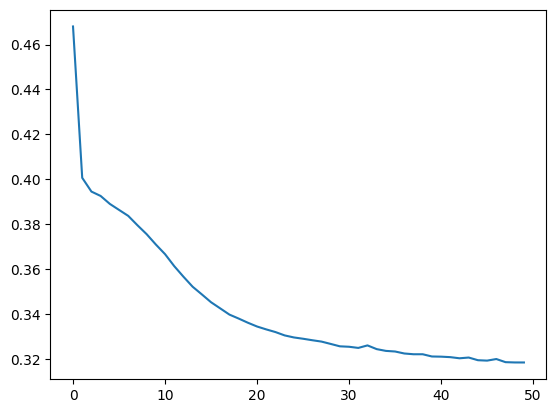

In [21]:
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("MSE por época")
plt.legend(); plt.show()


### Evaluación en test (métricas por horizonte)

In [22]:
# Construye ventanas en test (usa historia en test_s; puede quedar menos denso)
X_test, y_test = build_dataset(df_test_s, window=WINDOW, horizon=HORIZON)
X_test = X_test[..., None]
print("Test shapes:", X_test.shape, y_test.shape)

# Predicción estandarizada
y_pred_std = model.predict(X_test, verbose=0)

# Para métricas en ventas originales, re-escala por serie.
# Opción simple: métricas en espacio estandarizado. Opción completa: reconstrucción por ventana y serie.
# Aquí daremos métricas en estándar (consistente con entrenamiento) + ejemplo de desestandarización para plotting.

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test.ravel(), y_pred_std.ravel())
mse = mean_squared_error(y_test.ravel(), y_pred_std.ravel())
rmse = math.sqrt(mse)
print(f"MAE(std)={mae:.4f}  MSE(std)={mse:.4f}  RMSE(std)={rmse:.4f}")


Test shapes: (0, 60, 1) (0, 90)


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

### 10. Forecast 90 días por serie y gráfico (desestandarizado)

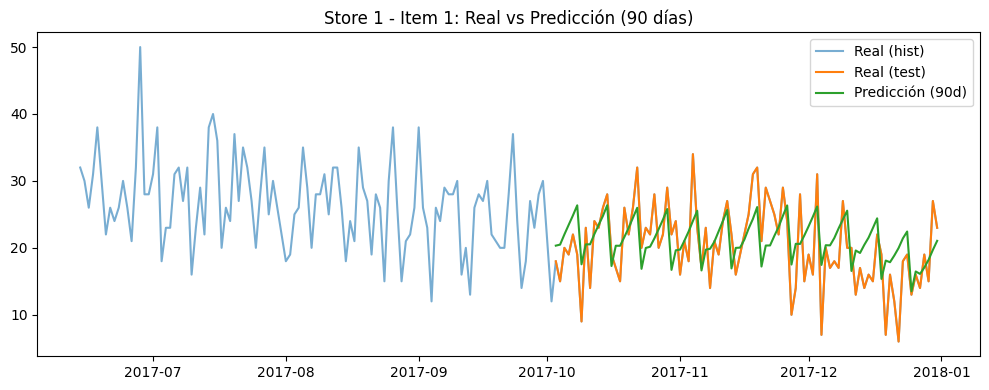

In [23]:
def inverse_series(y_std, mu, sd):
    return y_std * sd + mu

# Tomemos una serie ejemplo (store=1, item=1) y graficamos últimos 200 días + predicción 90 días
SAMP_STORE, SAMP_ITEM = 1, 1

g_all = df[df["store"].eq(SAMP_STORE) & df["item"].eq(SAMP_ITEM)].sort_values("date").copy()
g_train = df_train_s[(df_train_s["store"].eq(SAMP_STORE)) & (df_train_s["item"].eq(SAMP_ITEM))].sort_values("date")
g_val   = df_val_s[(df_val_s["store"].eq(SAMP_STORE)) & (df_val_s["item"].eq(SAMP_ITEM))].sort_values("date")
g_test  = df_test_s[(df_test_s["store"].eq(SAMP_STORE)) & (df_test_s["item"].eq(SAMP_ITEM))].sort_values("date")

mu, sd = stats.get((SAMP_STORE, SAMP_ITEM), (0.0,1.0))

# Construimos la última ventana que termina justo ANTES del periodo de test completo
g_concat = pd.concat([g_train, g_val], axis=0).sort_values("date")
y_hist = g_concat["y"].values

if len(y_hist) >= WINDOW:
    lastX = y_hist[-WINDOW:].astype(np.float32)[None, :, None]
    yhat_std = model.predict(lastX, verbose=0)[0]  # (90,)
    yhat = inverse_series(yhat_std, mu, sd)

    # Serie real en test (ventas originales)
    real = df_test[(df_test["store"].eq(SAMP_STORE)) & (df_test["item"].eq(SAMP_ITEM))].sort_values("date")["sales"].values[:PRED_STEPS]

    # Eje temporal
    last_hist_dates = g_concat["date"].iloc[-WINDOW:]
    future_dates = pd.date_range(start=df_test["date"].min(), periods=PRED_STEPS, freq="D")

    plt.figure(figsize=(10,4))
    # mostramos últimos 200 días de la serie original
    mask200 = g_all["date"] >= (g_all["date"].max() - pd.Timedelta(days=200))
    plt.plot(g_all.loc[mask200, "date"], g_all.loc[mask200, "sales"], label="Real (hist)", alpha=0.6)
    plt.plot(future_dates, real, label="Real (test)")
    plt.plot(future_dates, yhat, label="Predicción (90d)")
    plt.title(f"Store {SAMP_STORE} - Item {SAMP_ITEM}: Real vs Predicción (90 días)")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No hay suficiente historia para armar la ventana de ejemplo.")


### 11. Forecast para todas las series (entrega/uso general)

In [24]:
def forecast_series(df_train_s, df_val_s, model, window=WINDOW, horizon=HORIZON):
    # última ventana usando train+val por serie
    preds = []
    dates0 = df_test["date"].min()
    for (s,i), gtv in pd.concat([df_train_s, df_val_s]).groupby(["store","item"]):
        y_hist = gtv.sort_values("date")["y"].values
        if len(y_hist) < window:
            continue
        lastX = y_hist[-window:].astype(np.float32)[None,:,None]
        yhat_std = model.predict(lastX, verbose=0)[0]
        mu, sd = stats.get((s,i), (0.0,1.0))
        yhat = inverse_series(yhat_std, mu, sd)
        df_out = pd.DataFrame({
            "store": s, "item": i,
            "date": pd.date_range(start=dates0, periods=horizon, freq="D"),
            "pred": yhat
        })
        preds.append(df_out)
    return pd.concat(preds, axis=0).reset_index(drop=True) if preds else pd.DataFrame()

preds_all = forecast_series(df_train_s, df_val_s, model)
preds_all.head()


,store,item,date,pred
0,1,1,2017-10-03,20.330740
1,1,1,2017-10-04,20.482159
2,1,1,2017-10-05,21.998514
3,1,1,2017-10-06,23.426908
4,1,1,2017-10-07,24.846222


### 12. Métricas por serie

In [26]:
df_test_real = df_test[["store","item","date","sales"]].copy()
eval_df = preds_all.merge(df_test_real, on=["store","item","date"], how="inner")
from sklearn.metrics import mean_absolute_error, mean_squared_error

metrics = []
for (s,i), g in eval_df.groupby(["store","item"]):
    mae = mean_absolute_error(g["sales"], g["pred"])
    mse = mean_squared_error(g["sales"], g["pred"])
    rmse = math.sqrt(mse)
    metrics.append({"store": s, "item": i, "MAE": mae, "RMSE": rmse})
metrics_df = pd.DataFrame(metrics).sort_values("RMSE").reset_index(drop=True)
metrics_df.head(10)

,store,item,MAE,RMSE
0,7,47,3.040397,3.916990
1,6,47,3.049029,4.014886
2,5,5,3.171560,4.110742
3,6,37,3.425309,4.151029
4,7,1,3.217356,4.234818
5,7,4,3.228260,4.244475
6,6,5,3.291293,4.257875
7,6,1,3.538552,4.294155
8,6,41,3.524507,4.370567
9,7,34,3.790344,4.518017
